In [1]:
%load_ext autoreload
%autoreload 3


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Set
import abc


history [3865, 5206, 712, 4333, 50, 9034, 8404, 6994, 3284, 7518, 5314, 3282, 5170, 1366, 2752, 8408, 446, 9198, 168, 4420, 4156, 9138, 5569, 707, 2607, 4512, 4734, 16, 12, 9937, 5282, 2867, 8765, 716, 6576, 4427, 3014, 49, 5205, 3802, 3416, 4656, 2216, 5673, 7332, 6977, 7564, 7184, 3370, 3368, 9917, 7310, 6257, 6250, 5786, 40, 432, 7090, 1598, 4986, 533, 2409, 473, 2268, 1298, 1084, 748, 1896, 3902, 7998, 8962, 8052, 6413, 4985, 6717, 6623, 980, 9455, 5912, 4159, 5326, 1139, 2040, 1612, 4928, 9856, 5685, 4282, 2407, 9768, 939, 4557, 5185, 6235, 9046, 2370, 9866, 1679, 9220, 8677, 8273, 8510, 1083, 9772, 5126, 7805, 966, 9031, 984, 4400, 1286, 9941, 7032, 7508, 2314, 7541, 3411, 2631, 5921, 252, 1781, 1970, 7959, 5632, 7363, 5632, 916, 5343, 2108, 2830, 2651, 1628, 1821, 5424, 8939, 2025, 236, 6881, 1484, 6014, 5173, 5838, 854, 4265, 2270, 8506, 4435, 4888, 7570, 2875, 4249, 9659, 9094, 9447, 8454, 3668, 7490, 2149, 5861, 5685, 4741, 9278, 2041, 3222, 6678, 6060, 3232, 4574, 8696, 3345

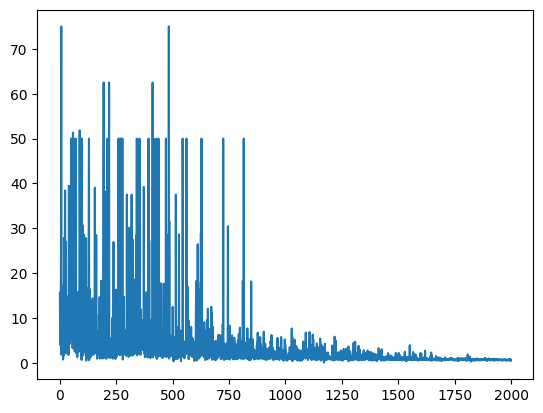

In [3]:
from markov_generator import RandomMarkovGenerator
from ffm import train_ffm, FieldAwareFactorizationMachine

# Those are somewhat good parameters
n = 10000  # Number of distinct pages
h = 10  # History length
m = h+2    # Number of fields (example value, h + 2)
k = 5   # Size of the latent factors


ffm = FieldAwareFactorizationMachine(n, m, k)
history = RandomMarkovGenerator(n).generate_sequence(1000)

cache = set(np.random.randint(0, n, size=20))
context = history[:h]

print("history", history)
print("cache", cache)
print("context", context)

losses= train_ffm(ffm, history, cache, h, epochs=2000, lr=0.01, wd=0.1, epoch_samples=4)

a, b = np.random.choice(list(cache), 2, replace=False)

print(f"p({a}, {b}) = ", ffm([a, b]+ context))
print(f"p({b}, {a}) = ", ffm([b, a]+ context))

plt.plot(losses)


In [125]:
from cache import Cache
from eviction import LRU, DOM, MQ, RandomEvictor
from prefetch import Next, Markov
from prob_model import FFM


# Tests on Markov generated traces

In [39]:
SEQ_LEN = 10000
N = 100  # Address space size
SEQ_COUNT = 3  # Number of sequences to generate
CACHE_SIZE = 8

sequences = [
    RandomMarkovGenerator(N).generate_sequence(SEQ_LEN)
    for _ in range(SEQ_COUNT)
]


In [40]:
import time


def test_cache(cache: Cache, requests: List[int]) -> int:
    """Returns cache miss count for given cache and requests."""
    time_start = time.time()

    misses = 0
    for r in requests:
        if not cache.read(r):
            misses += 1

    time_end = time.time()

    print(f"Time taken: {time_end - time_start:.2f}s")
    print(f"Misses: {misses}")
    print(f"Hit rate: {1 - misses / len(requests):.3f}")

    return misses


In [41]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "MQ",
        eviction_strategy=MQ(),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0
Time taken: 0.02s
Misses: 9155
Hit rate: 0.085
Sequence 1
Time taken: 0.02s
Misses: 9256
Hit rate: 0.074
Sequence 2
Time taken: 0.02s
Misses: 9267
Hit rate: 0.073


In [26]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "LRU",
        eviction_strategy=LRU(),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0
Time taken: 0.02s
Misses: 9213
Hit rate: 0.079
Sequence 1
Time taken: 0.02s
Misses: 9131
Hit rate: 0.087
Sequence 2
Time taken: 0.02s
Misses: 9189
Hit rate: 0.081


In [27]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0
Time taken: 0.05s
Misses: 9236
Hit rate: 0.076
Sequence 1
Time taken: 0.05s
Misses: 9191
Hit rate: 0.081
Sequence 2
Time taken: 0.05s
Misses: 9270
Hit rate: 0.073


In [28]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "LRU",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0
Time taken: 0.05s
Misses: 9236
Hit rate: 0.076
Sequence 1
Time taken: 0.05s
Misses: 9191
Hit rate: 0.081
Sequence 2
Time taken: 0.05s
Misses: 9270
Hit rate: 0.073


In [29]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "LRU + MARKOV(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(2),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0
Time taken: 0.06s
Misses: 9218
Hit rate: 0.078
Sequence 1
Time taken: 0.06s
Misses: 9161
Hit rate: 0.084
Sequence 2
Time taken: 0.06s
Misses: 9248
Hit rate: 0.075


In [11]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "DOM(FFM) + NEXT",
        eviction_strategy=DOM(prob_model=FFM(n=N)),
        prefetch_strategy=Next(),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0
Time taken: 402.90s
Misses: 9910
Hit rate: 0.009
Sequence 1
Time taken: 18711.79s
Misses: 9918
Hit rate: 0.008
Sequence 2
Time taken: 248.30s
Misses: 9927
Hit rate: 0.007


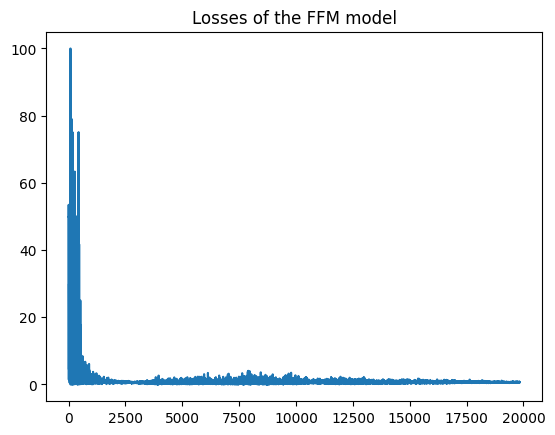

In [12]:
# To check if it's learning anything
plt.plot(cache.eviction_strategy.prob_model.losses)
plt.title("Losses of the FFM model")
plt.show()


In [13]:
from hwi_dataset import read_trace, get_test_set, get_reads, get_page_requests

test_set = get_test_set()

read_trace(test_set['1'][0][0])


,timestamp,tp,opCode,result,volumeId,objId,objLba,length,timepoint,last time nano,print data
NaN,Thu Nov 2 02:06:06 2017,PREFETCH,0x128001,0,0x59,0x59,173727232,16,1,18648389670988403,0
NaN,Thu Nov 2 02:06:06 2017,PREFETCH_DONE,0x128001,0,0x59,0x59,173727232,16,1,18648389671626787,c6d4d4e00000a206
NaN,Thu Nov 2 02:06:06 2017,READ_DONE,0x128001,0,0x59,0x59,173727232,16,1,18648389671637504,c6d4d4e00000a206
NaN,Thu Nov 2 02:06:06 2017,READ,0x128001,0,0x59,0x59,640764784,16,1,18648389674379950,0
NaN,Thu Nov 2 02:06:06 2017,PREFETCH,0x128001,0,0x59,0x59,640764784,16,1,18648389674396012,0
...,...,...,...,...,...,...,...,...,...,...,...
NaN,Thu Nov 2 02:07:59 2017,READ_DONE,0x128001,0,0x59,0x59,178450160,16,1,18648502893706999,c6a2f7ef0000a206
NaN,Thu Nov 2 02:07:59 2017,READ,0x128001,0,0x59,0x59,406216112,16,1,18648502958439917,0
NaN,Thu Nov 2 02:07:59 2017,PREFETCH,0x128001,0,0x59,0x59,406216112,16,1,18648502958455111,0
NaN,Thu Nov 2 02:07:59 2017,PREFETCH_DONE,0x128001,0,0x59,0x59,406216112,16,1,18648502959057908,ba858bdb0000a206


In [260]:
import dataclasses
import copy
import tqdm
import math

@dataclasses.dataclass
class TestResult:

    cache_name: str
    miss_count: int
    trace_length: int
    unique_addresses: int
    execution_time: float


    def __repr__(self) -> str:
        return (
            f"Cache name: {self.cache_name}\n"
            f"Miss count: {self.miss_count}\n"
            f"Trace length: {self.trace_length}\n"
            f"Unique addresses: {self.unique_addresses}\n"
            f"Miss rate: {self.miss_count / self.trace_length}\n"
            f"Execution time: {self.execution_time}"
        )

def test_case(test_dir_name: str, cache: Cache, page_size=16*1024) -> TestResult:
    start_time = time.time()
    total_misses = 0
    total_length = 0

    unique_addresses = set()
    uc = set()
    cache_factory = lambda: copy.deepcopy(cache)

    for volume_paths in sorted(test_set[test_dir_name]):
        cache = cache_factory()

        print(f"Volume {volume_paths[0].split('/')[-2]}")

        for path in tqdm.tqdm(volume_paths):
            hits = 0

            requests = get_page_requests(get_reads(read_trace(path)), page_size=page_size)

            for r in requests:
                unique_addresses.add(r)
                uc.add((i, r))
                hit = cache.read(r)
                hits += hit

            total_misses += len(requests) - hits
            total_length += len(requests)

    return TestResult(
        cache_name=cache.name,
        miss_count=total_misses,
        unique_addresses=len(unique_addresses),
        trace_length=total_length,
        execution_time=round(time.time() - start_time, 3)
    )


In [68]:
test_dirs = [
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
]


test_caches = [

    Cache(
        "DOM(FFM)",
        eviction_strategy=DOM(prob_model=FFM(n=300, k=100, h=6)),
        prefetch_strategy=None,
        p=1,
        size=8
    )
]


In [256]:
test_case(
    '2',
    cache=Cache(
        "DOM(FFM)",
        eviction_strategy=DOM(prob_model=FFM(n=300, k=10, h=14)),
        prefetch_strategy=Next(),
        size=16
    )
)


Volume cache_trace_3


  0%|          | 0/11 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [239]:
test_case(
    '2',
    cache=Cache(
        "DOM(FFM)",
        eviction_strategy=DOM(prob_model=FFM(n=10000, k=10, h=14)),
        prefetch_strategy=Next(),
        size=16
    ),
    page_size=512
)


Volume cache_trace_3


  0%|          | 0/11 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [259]:
test_case(
    '2',
    cache=Cache(
        "LRU + Markov(2)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(3),
        size=16
    ),
    page_size=16*1024
)


Volume cache_trace_3


100%|██████████| 11/11 [00:00<00:00, 17.92it/s]


Volume cache_trace_6


100%|██████████| 17/17 [00:00<00:00, 23.43it/s]


Volume cache_trace_9


100%|██████████| 16/16 [00:00<00:00, 25.62it/s]


Cache name: LRU + Markov(2)
Miss count: 5520
Trace length: 112913
Unique addresses: 2797
Miss rate: 0.04888719633700282
Execution time: 2.451

In [250]:
test_case(
    '2',
    cache=Cache(
        "MQ",
        eviction_strategy=MQ(max_frequency=8, life_time=5, qout_size=16*4),
        prefetch_strategy=Next(),
        size=16
    ),
    page_size=16
)


Volume cache_trace_3


100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


Volume cache_trace_6


100%|██████████| 17/17 [00:03<00:00,  4.32it/s]


Volume cache_trace_9


100%|██████████| 16/16 [00:02<00:00,  6.88it/s]


Miss count: 40930
Trace length: 1913360
Unique addresses: 450595
Miss rate: 0.021391687920725842

In [185]:
test_case(
    '2',
    cache=Cache(
        "MQ",
        eviction_strategy=RandomEvictor(),
        prefetch_strategy=Next(),
        size=8,
    ),
    page_size=16*1024
)


Volume cache_trace_3


100%|██████████| 11/11 [00:00<00:00, 13.13it/s]


Volume cache_trace_6


100%|██████████| 17/17 [00:01<00:00, 14.04it/s]


Volume cache_trace_9


100%|██████████| 16/16 [00:00<00:00, 17.64it/s]


Miss count: 4928
Trace length: 112913
Unique addresses: 2797
Miss rate: 0.04364422165738223

In [242]:
from opt import opt_cache_simulation


def get_opt_for_test_dir(test_set_dir, page_size=16*1024, cache_size=8) -> TestResult:
    total_misses = 0
    total_length = 0
    unique_addresses = set()

    for volume_paths in sorted(test_set[test_set_dir]):

        for path in volume_paths:
            requests = get_page_requests(get_reads(read_trace(path)), page_size=page_size)
            total_length += len(requests)
            unique_addresses.update(requests)

            misses = opt_cache_simulation(volume_paths, cache_size)
            total_misses += misses

    return TestResult(
        cache_name="OPT",
        miss_count=total_misses,
        unique_addresses=len(unique_addresses),
        trace_length=total_length,
    )


print(get_opt_for_test_dir('1', page_size=256))
#print(get_opt_for_test_dir('2'))


Miss count: 2763
Trace length: 189976
Unique addresses: 140215
Miss rate: 0.014543942392723292



In [270]:
import pandas as pd


test_dirs = [
    '1',
    '2',
    '3',
    '11'
    'scenario_test_trace_simple/VDI_virus_scan'
]

caches_size_8 = [
    Cache(
        "LRU",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=8
    ),
    Cache(
        "MQ",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        size=8
    ),
    Cache(
        "DOM(FFM(n=1000,k=10,h=14))",
        eviction_strategy=DOM(prob_model=FFM(n=1000, k=10, h=14)),
        prefetch_strategy=Next(),
        size=8
    ),
    Cache(
        "DOM(FFM(n=10000,k=10,h=14))",
        eviction_strategy=DOM(prob_model=FFM(n=10000, k=10, h=14)),
        prefetch_strategy=Next(),
        size=8
    ),
    Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=8
    ),
    Cache(
        "LRU + Markov(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=8
    ),
    Cache(
        "MQ + NEXT",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Next(),
        size=8
    ),
    Cache(
        "DOM(FFM(n=1000,k=10,h=14)) + NEXT",
        eviction_strategy=DOM(prob_model=FFM(n=1000, k=10, h=14)),
        prefetch_strategy=Next(),
        size=8
    ),
]

def test(caches: List[Cache], test_dirs: List[str], page_size=16*1024) -> pd.DataFrame:
    rows = []
    for test_dir in test_dirs:
        for cache in caches:
            print("=======================================")
            print(f"Test dir: {test_dir}, cache: {cache.name}")
            print("=======================================")
            test_result = test_case(test_dir, cache, page_size=page_size)
            rows.append({
                'test_dir': test_dir,
                'cache': cache.name,
                'miss_count': test_result.miss_count,
                'trace_length': test_result.trace_length,
                'unique_addresses': test_result.unique_addresses,
                'page_size': page_size,
                'execution_time': test_result.execution_time
            })
            res = pd.DataFrame(rows)

            res.to_csv(f'results_{page_size}.csv')

    return res


In [271]:
test(caches_size_8, test_dirs, page_size=16*1024)


Test dir: 1, cache: LRU
Volume cache_trace_116


100%|██████████| 29/29 [00:01<00:00, 21.43it/s]


Volume cache_trace_593


100%|██████████| 31/31 [00:01<00:00, 23.05it/s]


Volume cache_trace_89


100%|██████████| 31/31 [00:01<00:00, 22.08it/s]


Test dir: 1, cache: MQ
Volume cache_trace_116


100%|██████████| 29/29 [00:01<00:00, 22.33it/s]


Volume cache_trace_593


100%|██████████| 31/31 [00:01<00:00, 22.29it/s]


Volume cache_trace_89


100%|██████████| 31/31 [00:01<00:00, 22.20it/s]


Test dir: 1, cache: DOM(FFM(n=1000,k=10,h=14))
Volume cache_trace_116


100%|██████████| 29/29 [45:03<00:00, 93.21s/it]   


Volume cache_trace_593


100%|██████████| 31/31 [43:08<00:00, 83.51s/it] 


Volume cache_trace_89


100%|██████████| 31/31 [55:12<00:00, 106.84s/it]


Test dir: 1, cache: DOM(FFM(n=10000,k=10,h=14))
Volume cache_trace_116


100%|██████████| 29/29 [38:58<00:00, 80.63s/it]


Volume cache_trace_593


100%|██████████| 31/31 [54:38<00:00, 105.76s/it]


Volume cache_trace_89


100%|██████████| 31/31 [1:10:36<00:00, 136.66s/it]


Test dir: 1, cache: LRU + NEXT
Volume cache_trace_116


100%|██████████| 29/29 [00:01<00:00, 22.52it/s]


Volume cache_trace_593


100%|██████████| 31/31 [00:01<00:00, 23.68it/s]


Volume cache_trace_89


100%|██████████| 31/31 [00:01<00:00, 22.19it/s]


Test dir: 1, cache: LRU + Markov(3)
Volume cache_trace_116


100%|██████████| 29/29 [00:01<00:00, 22.37it/s]


Volume cache_trace_593


100%|██████████| 31/31 [00:01<00:00, 24.35it/s]


Volume cache_trace_89


100%|██████████| 31/31 [00:01<00:00, 23.06it/s]


Test dir: 1, cache: MQ + NEXT
Volume cache_trace_116


100%|██████████| 29/29 [00:01<00:00, 19.68it/s]


Volume cache_trace_593


100%|██████████| 31/31 [00:01<00:00, 21.08it/s]


Volume cache_trace_89


100%|██████████| 31/31 [00:01<00:00, 20.03it/s]


Test dir: 1, cache: DOM(FFM(n=1000,k=10,h=14)) + NEXT
Volume cache_trace_116


100%|██████████| 29/29 [29:33<00:00, 61.17s/it]


Volume cache_trace_593


100%|██████████| 31/31 [41:54<00:00, 81.13s/it] 


Volume cache_trace_89


100%|██████████| 31/31 [55:16<00:00, 106.99s/it]


Test dir: 2, cache: LRU
Volume cache_trace_3


100%|██████████| 11/11 [00:00<00:00, 21.64it/s]


Volume cache_trace_6


100%|██████████| 17/17 [00:00<00:00, 25.66it/s]


Volume cache_trace_9


100%|██████████| 16/16 [00:00<00:00, 30.20it/s]


Test dir: 2, cache: MQ
Volume cache_trace_3


100%|██████████| 11/11 [00:00<00:00, 20.71it/s]


Volume cache_trace_6


100%|██████████| 17/17 [00:00<00:00, 25.30it/s]


Volume cache_trace_9


100%|██████████| 16/16 [00:00<00:00, 30.63it/s]


Test dir: 2, cache: DOM(FFM(n=1000,k=10,h=14))
Volume cache_trace_3


100%|██████████| 11/11 [00:59<00:00,  5.42s/it]


Volume cache_trace_6


100%|██████████| 17/17 [05:00<00:00, 17.66s/it]


Volume cache_trace_9


100%|██████████| 16/16 [01:35<00:00,  5.96s/it]


Test dir: 2, cache: DOM(FFM(n=10000,k=10,h=14))
Volume cache_trace_3


100%|██████████| 11/11 [01:06<00:00,  6.02s/it]


Volume cache_trace_6


100%|██████████| 17/17 [05:47<00:00, 20.43s/it]


Volume cache_trace_9


100%|██████████| 16/16 [02:02<00:00,  7.65s/it]


Test dir: 2, cache: LRU + NEXT
Volume cache_trace_3


100%|██████████| 11/11 [00:00<00:00, 21.74it/s]


Volume cache_trace_6


100%|██████████| 17/17 [00:00<00:00, 25.74it/s]


Volume cache_trace_9


100%|██████████| 16/16 [00:00<00:00, 30.24it/s]


Test dir: 2, cache: LRU + Markov(3)
Volume cache_trace_3


100%|██████████| 11/11 [00:00<00:00, 22.47it/s]


Volume cache_trace_6


100%|██████████| 17/17 [00:00<00:00, 26.69it/s]


Volume cache_trace_9


100%|██████████| 16/16 [00:00<00:00, 31.10it/s]


Test dir: 2, cache: MQ + NEXT
Volume cache_trace_3


100%|██████████| 11/11 [00:00<00:00, 19.15it/s]


Volume cache_trace_6


100%|██████████| 17/17 [00:00<00:00, 24.55it/s]


Volume cache_trace_9


100%|██████████| 16/16 [00:00<00:00, 29.75it/s]


Test dir: 2, cache: DOM(FFM(n=1000,k=10,h=14)) + NEXT
Volume cache_trace_3


100%|██████████| 11/11 [01:03<00:00,  5.76s/it]


Volume cache_trace_6


100%|██████████| 17/17 [04:54<00:00, 17.31s/it]


Volume cache_trace_9


100%|██████████| 16/16 [01:30<00:00,  5.68s/it]


Test dir: 3, cache: LRU
Volume trace_150_0


100%|██████████| 24/24 [00:00<00:00, 32.79it/s]


Volume trace_151_0


100%|██████████| 31/31 [00:00<00:00, 31.80it/s]


Volume trace_152_0


100%|██████████| 24/24 [00:00<00:00, 32.89it/s]


Volume trace_153_0


100%|██████████| 12/12 [00:00<00:00, 29.54it/s]


Volume trace_201_0


100%|██████████| 21/21 [00:00<00:00, 37.85it/s]


Test dir: 3, cache: MQ
Volume trace_150_0


100%|██████████| 24/24 [00:00<00:00, 32.93it/s]


Volume trace_151_0


100%|██████████| 31/31 [00:01<00:00, 30.67it/s]


Volume trace_152_0


100%|██████████| 24/24 [00:00<00:00, 32.35it/s]


Volume trace_153_0


100%|██████████| 12/12 [00:00<00:00, 28.80it/s]


Volume trace_201_0


100%|██████████| 21/21 [00:00<00:00, 39.30it/s]


Test dir: 3, cache: DOM(FFM(n=1000,k=10,h=14))
Volume trace_150_0


100%|██████████| 24/24 [04:41<00:00, 11.74s/it]


Volume trace_151_0


100%|██████████| 31/31 [10:15<00:00, 19.87s/it]


Volume trace_152_0


100%|██████████| 24/24 [09:26<00:00, 23.62s/it]


Volume trace_153_0


100%|██████████| 12/12 [07:34<00:00, 37.85s/it]


Volume trace_201_0


100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Test dir: 3, cache: DOM(FFM(n=10000,k=10,h=14))
Volume trace_150_0


100%|██████████| 24/24 [05:48<00:00, 14.51s/it]


Volume trace_151_0


100%|██████████| 31/31 [12:19<00:00, 23.86s/it]


Volume trace_152_0


100%|██████████| 24/24 [10:22<00:00, 25.96s/it]


Volume trace_153_0


100%|██████████| 12/12 [09:48<00:00, 49.04s/it]


Volume trace_201_0


100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


Test dir: 3, cache: LRU + NEXT
Volume trace_150_0


100%|██████████| 24/24 [00:00<00:00, 32.33it/s]


Volume trace_151_0


100%|██████████| 31/31 [00:00<00:00, 31.42it/s]


Volume trace_152_0


100%|██████████| 24/24 [00:00<00:00, 32.37it/s]


Volume trace_153_0


100%|██████████| 12/12 [00:00<00:00, 29.34it/s]


Volume trace_201_0


100%|██████████| 21/21 [00:00<00:00, 37.28it/s]


Test dir: 3, cache: LRU + Markov(3)
Volume trace_150_0


100%|██████████| 24/24 [00:00<00:00, 33.92it/s]


Volume trace_151_0


100%|██████████| 31/31 [00:00<00:00, 32.37it/s]


Volume trace_152_0


100%|██████████| 24/24 [00:00<00:00, 31.97it/s]


Volume trace_153_0


100%|██████████| 12/12 [00:00<00:00, 29.64it/s]


Volume trace_201_0


100%|██████████| 21/21 [00:00<00:00, 27.43it/s]


Test dir: 3, cache: MQ + NEXT
Volume trace_150_0


100%|██████████| 24/24 [00:01<00:00, 22.81it/s]


Volume trace_151_0


100%|██████████| 31/31 [00:01<00:00, 27.27it/s]


Volume trace_152_0


100%|██████████| 24/24 [00:00<00:00, 28.54it/s]


Volume trace_153_0


100%|██████████| 12/12 [00:00<00:00, 25.83it/s]


Volume trace_201_0


100%|██████████| 21/21 [00:00<00:00, 37.96it/s]


Test dir: 3, cache: DOM(FFM(n=1000,k=10,h=14)) + NEXT
Volume trace_150_0


100%|██████████| 24/24 [04:50<00:00, 12.09s/it]


Volume trace_151_0


 19%|█▉        | 6/31 [02:01<06:58, 16.73s/it]